## Getting Started 
Tiramisu is a polyhedral framework designed to generate high-performance code for multiple platforms including multicores, GPUs, and distributed machines. TIRAMISU introduces a scheduling language with novel commands to explicitly manage the complexities that arise when targeting these systems.

pytorch_tiramisu is a python package that integrates Tiramisu Deep Learning Compiler to PyTorch Deep Learning Framework. The purpose of this integration is to benefit from Tiramisu optimizations transparently when using PyTorch. 

### Usage 

* pytorch_tiramisu can hook into PyTorch JIT and compile the model operators that it supports. (if jit parameter is set to True) 

In this case the user doesn't have to know anything about tiramisu and tiramisu directly uses its optimized operators to replace PyTorch current JIT.

NOTE : By default the mode of installation is 1. If you installed Tiramisu you should precise it when enabling the package. pt.enable(mode=2, jit=False) 

In [25]:
import torch 
import torch.nn.functional as F

A = torch.randn(1024)

@torch.jit.script
def relu_(a):
    return F.relu(a) 

print("-- Default IR --\n", relu_.graph_for(A))
print()

import pytorch_tiramisu as pt 
pt.enable(jit=True) 

# The following function will be compiled with Tiramisu
@torch.jit.script
def relu_tiramisu(a):
    return F.relu(a) 

print("-- Tiramisu IR --\n", relu_tiramisu.graph_for(A))

-- Default IR --
  
 graph(%A.1 : Float(*, *)):
  %result.2 : Float(*, *) = aten::relu(%A.1) # /home/hasus/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:914:17
  return (%result.2)

-- Tiramisu IR --
 
    1. A : (t_input) float {1024}
    2. relu_tiramisu : (t_opt) relu_tiramisu(%1.A)
    3. output : (t_output) float {1024}


Otherwise, pytorch_tiramisu.compile(model) can be used to perform the compilation of the deep learning model prior to running the final graph execution. 

In this case, the pytorch_tiramisu runs a bunch of passes through the model computation graph: 
1. **Fusion Pass** 
* **Compilation Pass**: that consists on optimizing and generating the operators for each node in the graph.
* **Execution Pass**


In [15]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import pytorch_tiramisu as pt 

pt.enable(jit=False) 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(256, 10)

    def forward(self, x):
        x = self.fc(x)
        return x
        
model = Net() 
a = torch.randn(1, 256)
generated = pt.compile(model(a)) # Execute an optimization pass and generate the operators.
pt.execute(generated) 

tensor([[ 0.5795,  0.2172, -0.2935, -1.1711,  0.0419,  0.6569, -0.4049, -0.2046,
          0.4880, -0.1260]])

### Fusion 
[Previous research](https://mboehm7.github.io/resources/ppopp2015.pdf) in the machine learning area has revealed opportunities for performance improvements from kernel fusion. This optimization can be used upon the compiler IR to fuse multiple operations together. 

In pytorch_tiramisu, the compiler automatically detects the pre-generated object files of the fused blocks (multiple operators) and use them whenever the model graph contains the same sequence of operators. For example, if the model contains Conv, Relu and then maxpool operators and the compiler finds the pre-compiled object file of the fused block Conv-Relu-Maxpool it will automatically fuse these three layers. 

On the other hand, if the user uses mode 2 of pytorch_tiramisu and wants to fuse operators that are independently registered in tiramisu, he or she can use the method pt.fuse() when defining the model. 

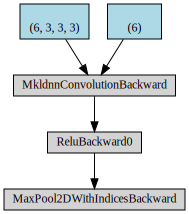

In [4]:
# Automatic Fusion 
import utils 
inputs = torch.randn(1,3,224,224)

# Model Definition
class Classifier(nn.Module):
    # define model layers
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        return x
    
model = Classifier()
y = model(inputs)

g = utils.make_dot(y)
g

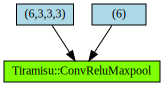

In [18]:
generated = pt.compile(model(inputs))
g = utils.make_dot_tiramisu(generated)
g

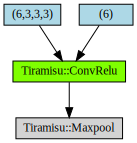

In [19]:
# Use pt.fuse 
# Model Definition
class Classifier(nn.Module):
    # define model layers
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = pt.fuse(nn.Sequential(
                                  nn.Conv2d(3, 6, 3),
                                  nn.ReLU()
                            ))    
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(self.conv1(x), (2, 2))
        return x
    
model = Classifier()
generated = pt.compile(model(inputs))
g = utils.make_dot_tiramisu(generated)
g